In [977]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import mdtraj as md

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams.update({'font.size': 11})
plt.rcParams['contour.negative_linestyle'] = 'dashed'

# CCR - the forward model

In terms of Bloch-Wangness-Redfield theory, remote CCR rates simply report on the zero spectral density, which is nothing else than the integral of the time correlation function (TCF), i.e., its enclosed area:
\begin{equation}
    \Gamma^{rem}_{\vec{u},\vec{v}} \propto J_{\vec{u},\vec{v}}(0) = \int_0^\infty C_{\vec{u},\vec{v}}(t) \,dt
\end{equation}

$\vec{u}$ and $\vec{v}$ represent motional vectors involved in the relaxation process corresponding to dipolar unit vectors or principal components of CSA tensors. The TCF in isotropic solution is:

\begin{equation} \label{eq:tcf_general}
    C_{\vec{u},\vec{v}}(t) = \langle P_2(\vec{u}(0)\cdot\vec{v}(t)) \rangle
\end{equation}

Angled brackets denote the ensemble average. In essence, the TCF encodes the average degree of correlation in $P_2$ between the vectors $\vec{u}$ and $\vec{v}$ after a time delay $t$. This might seem a little abstract at first. Let's consider a simple example, the auto-correlated dipolar relaxation of NH spin pairs in the backbone, $\vec{u} = \vec{v} = \vec{NH}$. $C_{\vec{u},\vec{u}}(t)$ starts off at $1$: At $t=0$, the NH bonds align with themselves. As time progresses and the protein molecules move in solution, the distribution of projection angles between $\vec{u}(0)$ and $\vec{v}(t)$ randomizes throughout the ensemble: $C_{\vec{u},\vec{u}}(t)$ decays due to the reorientational motions of the individual NH bonds.

We can extend this example by including the contribution of the axially symmetric $^{15}$N CSA tensor. As its unique axis $\vec{\sigma_{xx}} = \vec{v}$ is fixed to the dipolar unit vector $\vec{NH} = \vec{u}$ with an angle $\theta$, any motion experienced by $\vec{u}$ will also affect $\vec{v}$. $C_{\vec{u},\vec{v}}(t)$ starts off at $\langle P_2(\vec{u}(0)\cdot\vec{v}(0)) \rangle = P_2(\cos\theta)$ and decays as $t$ progresses. Since $\theta$ is fixed and relatively small, we can approximate:

\begin{equation} \label{eq:TCF_rigid_isotropic_approximation}
C_{\vec{u},\vec{v}}(t) \approx P_2(\cos\theta) C_{\vec{u},\vec{u}}(t) \approx P_2(\cos\theta) C_{\vec{v},\vec{v}}(t)
\end{equation}

The same approximation holds true for remote CCR rates if the angle between $\vec{u}$ and $\vec{v}$ is fixed. This corresponds to the assumption of a rigid (and isotropically tumbling) fold. Denoting $\theta$ as a function of the backbone dihedral angles $\phi$ and/or $\psi$, we get:

\begin{equation}
    \Gamma^{rem}_{\vec{u},\vec{v}} \propto P_2(\cos\theta(\phi,\psi))J_{\vec{u},\vec{u}}(0)
\end{equation}

In the presence of disorder, this gets more complicated. The angular degrees of freedom in the backbone not only govern the decorrelation process itself, they are also reflected in the TCF's amplitude $C_{\vec{u},\vec{v}}(0) = \langle P_2(\vec{u}(0)\cdot\vec{v}(0)) \rangle = \langle P_2(\cos\theta(\phi,\psi)) \rangle$. Both the amplitude and the decay of the TCF are generally unknown.

However, if the dynamics are somewhat comparable between different rates, observed variations should be mostly due to the amplitudes $\langle P_2(\cos\theta(\phi,\psi)) \rangle$. If we can define and extract a reasonable proxy for the normalized TCFs area, i.e, the "correlation time", we might be able to combine mutliple CCR rates with different ($\phi$,$\psi$)-dependencies to approximate the underlying ($\phi$,$\psi$)-distribution. 

Experimental and preliminary computational studies have shown that this indeed possible. While improvements and alternatives are still to be investigated, the above approximation based on the auto-correlated $J_{\vec{NH},\vec{NH}}(0)$ has proven a simple and adequate correlation time proxy in many scenarios.

We will illustrate this process below. First, provide the CCR rates you quantified as well as a $J(0)$ proxy from the literature.

We then define our forward models for all six CCR rates $\Gamma_i(\phi,\psi) = k_iP_2(\cos\theta(\phi,\psi))J(0)$ building on a predefined backbone geometry. We'll also introduce and define a few extra functions/concepts needed further down below.

In [1015]:
#provide the residue number i
residue_nr = 28

#provide your rates in s^-1

exp = {}
#measured on residue i+1 = "2"
exp['CaHa1_NHn2'] = -1.00969826949564

#measured on residue i = "1"
exp['CaHa1_NHn1'] = -2.30262939950309

#measured on residue i+1 = "2"
exp['NHn1_NHn2'] = 5.49712296638299

#measured on residue i+1 = "2"
exp['Ha1Hn2_CCSA1'] = 1.25326769676921

#measured on residue i+1 = "2"
exp['CaHa1_CCSA1'] = 6.73446976089051

#measured on residue i = "1"
exp['CaHa1_CCSA0'] = -9.98474886750829

#provide the experimental estimate for the auto-correlated NH-NH J(0)
#see Kaderavek et al. (2015), Supplementary Information, Table S4, column 3
J_0_estimate = 1.389


#####################

#optional parameters to overwrite

#adjust "order parameter" if you want to rescale the J_0_estimate
dynamic_scaling = 1.0

#delete rates you don't want to include in the analysis
included_rates = ['CaHa1_NHn2','CaHa1_NHn1','NHn1_NHn2','Ha1Hn2_CCSA1','CaHa1_CCSA1','CaHa1_CCSA0']

In [979]:
#provide the residue number i
residue_nr = 62

#provide your rates in s^-1

exp = {}
#measured on residue i+1 = "2"
exp['CaHa1_NHn2'] = -4.29355350079702

#measured on residue i = "1"
exp['CaHa1_NHn1'] = -11.4300983195023

#measured on residue i+1 = "2"
exp['NHn1_NHn2'] = 1.55053181134945

#measured on residue i+1 = "2"
exp['Ha1Hn2_CCSA1'] = 3.78267941005145

#measured on residue i+1 = "2"
exp['CaHa1_CCSA1'] = -9.4569000215266

#measured on residue i = "1"
exp['CaHa1_CCSA0'] = -2.31541020139655

#provide the experimental estimate for the auto-correlated NH-NH J(0)
#see Kaderavek et al. (2015), Supplementary Information, Table S4, column 3
J_0_estimate = 1.045


#####################

#optional parameters to overwrite

#adjust "order parameter" if you want to rescale the J_0_estimate
dynamic_scaling = 1.0

#delete rates you don't want to include in the analysis
included_rates = ['CaHa1_NHn2','CaHa1_NHn1','NHn1_NHn2','Ha1Hn2_CCSA1','CaHa1_CCSA1','CaHa1_CCSA0']

In [980]:
#provide the residue number i
residue_nr = 72

#provide your rates in s^-1

exp = {}
#measured on residue i+1 = "2"
exp['CaHa1_NHn2'] = -6.15561275346361

#measured on residue i = "1"
exp['CaHa1_NHn1'] = -6.09546407058238

#measured on residue i+1 = "2"
exp['NHn1_NHn2'] = 2.38992810901028

#measured on residue i+1 = "2"
exp['Ha1Hn2_CCSA1'] = 4.55040118134934

#measured on residue i+1 = "2"
exp['CaHa1_CCSA1'] = 0.412801092833432

#measured on residue i = "1"
exp['CaHa1_CCSA0'] = -2.6121008237153

#provide the experimental estimate for the auto-correlated NH-NH J(0)
#see Kaderavek et al. (2015), Supplementary Information, Table S4, column 3
#if the particular residue is not available, interpolate between i-1 and i+1, i.e. (J(0)_{i-1} + J(0)_{i+1})/2
#it is provided in ns, jst paste the value here, it will be converted to s later on
J_0_estimate = (1.162+0.621)/2


#####################

#optional parameters to overwrite

#adjust "order parameter" if you want to rescale the J_0_estimate
dynamic_scaling = 1.0

#delete rates you don't want to include in the analysis
included_rates = ['CaHa1_NHn2','CaHa1_NHn1','NHn1_NHn2','Ha1Hn2_CCSA1','CaHa1_CCSA1','CaHa1_CCSA0']

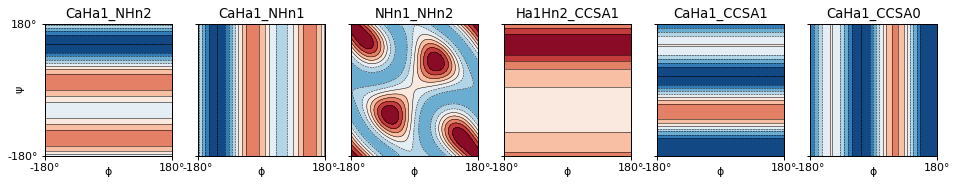

In [1016]:
#we need to define some physical constants and experimental paramaters

h_bar = 1.05457180013e-34
mu_naught = 4.0*np.pi*1.0e-7 
gamma_c = 67.262e6 
gamma_h = 267.513e6 
gamma_n = -27.116e6 

B_0 = 800e6*2*np.pi/gamma_h 

angstrom_correction = 1.0e10**3 #the geometry dependencies are calculated in Angstrom

CaHa_pref = mu_naught*h_bar/4/np.pi*gamma_h*gamma_c*angstrom_correction/(1.09**3)
NHn_pref = mu_naught*h_bar/4/np.pi*gamma_h*gamma_n*angstrom_correction/(1.02**3)
HaHn_pref = mu_naught*h_bar/4/np.pi*gamma_h*gamma_h*angstrom_correction
carbonyl_pref = B_0*gamma_c*2/3

CC = {} #these will contain the rates as a function of phi/psi
sigmas = {} #these will contain the expected variances, we keep it simple and set them to 1
E = {} #these will contain the experiments you chose above

for rate in included_rates:
    interactions = str(rate).split('_')
    prefactor = 1
    for interaction in interactions:
        if 'NHn' in interaction:
            prefactor *= NHn_pref
        elif 'CaHa' in interaction:
            prefactor *= CaHa_pref
        elif 'CCSA' in interaction:
            prefactor *= carbonyl_pref
        elif 'Ha1Hn2' in interaction:
            prefactor *= HaHn_pref
    #now we import the precalculated geometrical dependencies (assuming a standard backbone geometry)        
    #for the correlation time we use the NH-NH autocorrelated J(0) as a proxy
    physical_rate = np.loadtxt(str(rate)+'.csv',delimiter=',')*prefactor*J_0_estimate*1e-9*dynamic_scaling
    
    CC[str(rate)] = physical_rate
    #sigmas[str(rate)] = np.amax(physical_rate)-np.amin(physical_rate)
    sigmas[str(rate)] = 1.
    E[str(rate)] = exp[str(rate)]
    
#for comparison we use the ensemble of Lange, Griesinger et al. (2008), PDB code 2k39

t = md.load('./2k39.pdb') #the ensemble is deposted as a set of 3D structures, we treat it like an MD trajectory

phis_t = np.rad2deg(md.compute_phi(t)[1])
psis_t = np.rad2deg(md.compute_psi(t)[1])
phi_dict = {}
psi_dict = {}
phi_dict[residue_nr] = [phis_t[x][residue_nr-2] for x in range(len(phis_t))]
psi_dict[residue_nr] = [psis_t[x][residue_nr-1] for x in range(len(psis_t))]

#our chosen Ramachandran representation is a 360x360 array, which we define below  
phi_map = np.empty((360,360))
psi_map = np.empty((360,360))

for row, psi in enumerate(range(179,-181,-1)):
    for column, phi in enumerate(range(-180,180,+1)):
        phi_map[row,column] = phi
        psi_map[row,column] = psi
    
#below we define some functions needed for the MaxEnt treatment, no need to understand these!
def me_least_squares_normed_reg(L, E, CC, sigmas, tau, scaling, beta):
    
    summe = sum([L[index]*CC[key]*tau*scaling for index, key in enumerate(E)])
    norm = np.amax(summe)
    exp_sum = np.exp(summe-norm)
    partition = np.sum(prior*exp_sum)
    pdf_me = (prior/partition)*exp_sum
    
    diff = []
    for key in E:
        #for e in E[key]:
        diff.append((np.sum(pdf_me*CC[key]*tau*scaling)-E[key])/sigmas[key])
    if beta != 0:
        for i, key in enumerate(E):
            diff.append(L[i]*beta)
            
    return np.array(diff)

def jacobian_ls_normed_reg(L, E, CC, sigmas, tau, scaling, beta):
    
    summe = sum([L[index]*CC[key]*tau*scaling for index, key in enumerate(E)])
    norm = np.amax(summe)
    exp_sum = np.exp(summe-norm)
    partition = np.sum(prior*exp_sum)
    
    G = [CC[key] for key in E]
    row_counter = 0
    if beta != 0:
        jacobian_matrix = np.zeros([(sum([1 for x in E.values()])+len(L)), (len(L))])
        #print('jacobian with beta - correct')
    else:
        jacobian_matrix = np.zeros([(sum([1 for x in E.values()])), (len(L))])    
    for key in E:
        #for row_entry in range(len(E[key])):
        for column in range(len(L)):
            jacobian_matrix[row_counter,column] = 1/sigmas[key]*(np.sum(prior*CC[key]*tau*scaling*G[column]*tau*scaling*exp_sum)/partition -
                                                            (np.sum(prior*CC[key]*tau*scaling*exp_sum)*np.sum(prior*G[column]*tau*scaling*exp_sum))/(partition**2))
        row_counter += 1
        
    if beta !=0:
        for x in range(len(L)):
            for column in range(len(L)):
                if x == column:
                    jacobian_matrix[row_counter,column] = beta
                else:
                    jacobian_matrix[row_counter,column] = 0.
            
            row_counter += 1
                   
    return jacobian_matrix

#finally, let's plot the expected geometrical dependencies P2(cos(theta))
figure_width = 16

fig, axs = plt.subplots(1,6,figsize=(figure_width,figure_width/6.6))
for i, key in enumerate(CC):
    x = CC[key]

    if np.amin(x) < -np.amax(x):
        elev_max = -np.amin(x)
        elev_min = np.amin(x)
    else:
        elev_max = np.amax(x)
        elev_min = -np.amax(x)

    levels = np.linspace(elev_min,elev_max,steps)
    
    axs[i].contourf(np.flipud(x), levels, cmap=plt.cm.RdBu_r)
    axs[i].set_xticks([0,359])
    axs[i].set_xticklabels(['-180°','180°'])
    axs[i].set_yticks([0,359])
    if i == 0:
        axs[i].set_yticklabels(['-180°','180°'])
        axs[i].set_ylabel('$\mathregular{\psi}$')
    else:
        axs[i].set_yticklabels([])
    axs[i].set_xlabel('$\mathregular{\phi}$')
    axs[i].xaxis.labelpad = -8
    axs[i].yaxis.labelpad = -20
    axs[i].contour(np.flipud(x), levels, linewidths = .5, colors = 'k')
    axs[i].set_title(key)

# Bayes' theorem - A crashcourse

You have measured and quantified a set of 6 CCR rates $\Gamma_i^{exp}$, $i=1,\ldots,6$ or, in shorthand vectorial notation, $\vec{\Gamma}^{exp}$. We also defined our forward models $\Gamma_i(\phi,\psi)$ which relate the TCF amplitudes to the underlying $(\phi,\psi)$-space.

Assuming we have a (somewhat) rigid backbone, we now may ask: What $(\phi,\psi)$-pair would best explain our observations?

In terms of conditional probability, this translates to: What probability do we assign a $(\phi,\psi)$-pair *given* our observations, i.e., $P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big)$? This is simply the intersection "$\cap$" of possibilities: With the observations $\vec{\Gamma}^{exp}$ at hand, how likely is it due to $(\phi,\psi)$? This is the defintion of conditional probability:

\begin{align}
    P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) &= \frac{P\big((\phi,\psi)\cap\vec{\Gamma}^{exp}\big)}{P\big(\vec{\Gamma}^{exp}\big)}
\end{align}

Bayes' theorem is simply a way of rearranging this expression. We multiply by $P\big((\phi,\psi)\big) / P\big((\phi,\psi)\big) = 1$ and exploit the fact $P\big((\phi,\psi)\cap\vec{\Gamma}^{exp}\big) = P\big(\vec{\Gamma}^{exp}\cap(\phi,\psi)\big)$ which yields:

\begin{align}
    P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) &= \frac{P\big((\phi,\psi)\cap\vec{\Gamma}^{exp}\big)}{P\big(\vec{\Gamma}^{exp}\big)} = \frac{\dfrac{P\big((\phi,\psi)\cap\vec{\Gamma}^{exp}\big)}{P\big((\phi,\psi)\big)}P\big((\phi,\psi)\big)}{P\big(\vec{\Gamma}^{exp}\big)}\\
    &= \frac{P\big(\vec{\Gamma}^{exp}\vert(\phi,\psi)\big)P\big((\phi,\psi)\big)}{P\big(\vec{\Gamma}^{exp}\big)}
\end{align}

The probability $P\big(\vec{\Gamma}^{exp}\big)$ does not depend on $(\phi,\psi)$. Since we are only interested in comparing different realizations of $(\phi,\psi)$, $P\big(\vec{\Gamma}^{exp}\big)$ enters as a constant, so we can simplify:

\begin{align}
    P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) \propto P\big(\vec{\Gamma}^{exp}\vert(\phi,\psi)\big)P\big((\phi,\psi)\big)
\end{align}

In Bayesian terminology, this reads: The *Posterior* is proportional to the *Likelihood* times the *Prior*. We don't know the quantity of interest, the Posterior. But we are fully equipped to define Likelihood and Prior.

## A Likelihood estimator

Let's assume our data is very informative, i.e., sufficient to single out a $(\phi,\psi)$-pair from a very general set of possible values: All angles are equally likely, the prior $P\big((\phi,\psi)\big)$ is uniform, i.e., a constant. Then our posterior probability $P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big)$ reduces to the Likelihood.

The Likelihood connects the observed rates $\Gamma_i^{exp}$ with our forward models $\Gamma_i(\phi,\psi)$. A common assumption is a *Gaussian* Likelihood constructed from uncorrelated independent measurements, which is a product of Gaussians written either as a product of exponentials or, more conveniently, as a sum in the exponent:

\begin{align}
    P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) &\propto \exp \bigg(-\frac{\big(\Gamma_1^{exp}-\Gamma_1(\phi,\psi)\big)^2}{\sigma_1^2}\bigg) \times \exp \bigg(-\frac{\big(\Gamma_2^{exp}-\Gamma_2(\phi,\psi)\big)^2}{\sigma_2^2}\bigg) \times \ldots\\
    &\propto \exp \bigg(-\sum_{i=1}^6\frac{\big(\Gamma_i^{exp}-\Gamma_i(\phi,\psi)\big)^2}{\sigma_i^2}\bigg)
\end{align}

In essence, $(\phi,\psi)$-pairs with low squared residuals are considered more likely. We simplify by setting the variances $\sigma_i^2 = 1$ for all rates. The results are calculated below. For visualization purposes, let's look at the Gaussians individually:

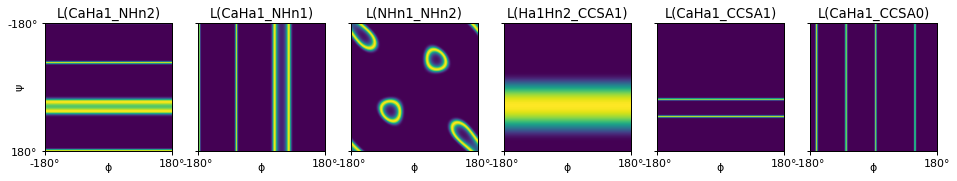

In [1027]:
figure_width = 16

Z_surface = {}

Z_product = 1.
Z_sum = 1.

fig, axs = plt.subplots(1,6,figsize=(figure_width,figure_width/6.6))

for i, key in enumerate(CC):
    Z_surface[key] = np.exp(-np.square(CC[key]-E[key])/sigmas[key])
    axs[i].set_xticks([0,359])
    axs[i].set_yticks([0,359])
    axs[i].set_title('L('+key+')')
    axs[i].set_xticklabels(['-180°','180°'])
    axs[i].set_xticklabels(['-180°','180°'])
    axs[i].set_xlabel('$\mathregular{\phi}$')
    axs[i].xaxis.labelpad = -8
    
    if i == 0:
        axs[i].set_yticklabels(['-180°','180°'])
        axs[i].set_ylabel('$\mathregular{\psi}$')

        axs[i].yaxis.labelpad = -20
    else:
        axs[i].set_yticklabels([])
    
    axs[i].imshow(Z_surface[key])    
    
    Z_product *= Z_surface[key]
    Z_sum += Z_surface[key]

The rates each constrain the space of possible $(\phi,\psi)$-values differently. Note how the $(\phi,\psi)$-dependencies of each rate determine the shape of the Gaussians.

As stated above, we are interested in the total Likelihood, i.e., the product of the Gaussians. For visualization purposes, we may also consider their overlap to provide a better "feel". How does it compare to the PDB ensemble of Lange et al.?

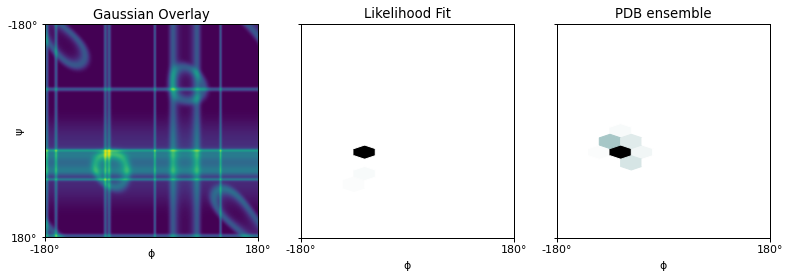

In [1029]:
figure_width = 13

fig, axs = plt.subplots(1,3,figsize=(figure_width,figure_width/3.3))

x1 = np.ndarray.flatten(phi_map)
y1 = np.ndarray.flatten(psi_map)
C1 = np.ndarray.flatten(Z_product)
grid = 10

axs[1].axis([-180,180,-180,180])
axs[1].set_xticks([-180,180])
axs[1].set_yticks([-180,180])
axs[1].set_xticklabels(['-180°','180°'])
axs[1].set_yticklabels([])
axs[1].set_xlabel('$\mathregular{\phi}$')
#axs[1].set_ylabel('$\mathregular{\psi}$')
axs[1].set_title('Likelihood Fit')
axs[1].hexbin(x1,y1,C1,gridsize=(grid,grid),cmap='bone_r',extent=[-180,180,-180,180])
#axs[1].xaxis.labelpad = -8

axs[0].set_xticks([0,359])
axs[0].set_yticks([0,359])
axs[0].set_xticklabels(['-180°','180°'])
axs[0].set_yticklabels(['-180°','180°'])
axs[0].set_xlabel('$\mathregular{\phi}$')
axs[0].set_ylabel('$\mathregular{\psi}$')
axs[0].set_title('Gaussian Overlay')
axs[0].xaxis.labelpad = -8
axs[0].yaxis.labelpad = -20
axs[0].imshow(Z_sum)

x2 = phi_dict[residue_nr]
y2 = psi_dict[residue_nr]

axs[2].axis([-180,180,-180,180])
axs[2].set_xticks([-180,180])
axs[2].set_yticks([-180,180])
axs[2].set_xticklabels(['-180°','180°'])
axs[2].set_yticklabels([])
axs[2].set_xlabel('$\mathregular{\phi}$')
#axs[1].set_ylabel('$\mathregular{\psi}$')
axs[2].set_title('PDB ensemble')
axs[2].hexbin(x2,y2,gridsize=(grid,grid),cmap='bone_r',extent=[-180,180,-180,180])

The way we constructed our Likelihood, we tend to find very sharp and localized peaks centered at the most probable realization of $(\phi,\psi)$. This is the case even if the underlying ensemble might exhibit some heterogeneity. Assuming a sharp unimodal solution, the CCR rates appear to constrain the $(\phi,\psi)$-space sufficiently. We could as well look for the maximum of our Posterior directly, which, in this case, is the maximum of the Likelihood. The above procedure therefore mimics a Maximum Likelihood estimator. For a Gaussian Likelihood, this corresponds to a very common and probably familiar fitting procedure:

\begin{align}
    \max_{\phi,\psi} P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) &= \max_{\phi,\psi} \log P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big) = \min_{\phi,\psi} -\log P\big((\phi,\psi)\vert\vec{\Gamma}^{exp}\big)\\
    &= \min_{\phi,\psi} \sum_{i=1}^6\frac{\big(\Gamma_i^{exp}-\Gamma_i(\phi,\psi)\big)^2}{\sigma_i^2} := \min_{\phi,\psi} \chi^2(\phi,\psi)
\end{align}

In essence, we did a simple $\chi^2$-fit, minimizing the squared distance between measured and calculated rates - assuming a rigid fold!

## Maximum A Posteriori (MAP)

By assuming a sharp peak in $(\phi,\psi)$-space, we drastically simplified the space of possible solutions; the Prior was assumed to be sparse. Clearly, this isn't always the case. If we allow for actual $(\phi,\psi)$-distributions $\vec{p}_{\phi,\psi}$, the Likelihood cannot be expected to carry the Posterior's mass alone due to the ambiguities that come with pronounced *ensemble averaging*. We must rewrite Bayes' theorem accordingly:

\begin{align}
    P\big(\vec{p}_{\phi,\psi}\vert\vec{\Gamma}^{exp}\big) \propto P\big(\vec{\Gamma}^{exp}\vert\vec{p}_{\phi,\psi}\big)P\big(\vec{p}_{\phi,\psi}\big)
\end{align}

Since we cannot assume the Likelihood to dominate the inference process, the Prior (a probability distribution over probability distributions!) might very well influence the result. The less informative the Likelihood *could* be, the more specific the Prior should be constructed.

Without showing a detailed derivation, we construct a similar point estimate from the posterior, this time treating the Prior explicitly in a so-called *Maximum A Posteriori* (MAP) estimate:
\begin{align}
    min_{\vec{p}_{\phi,\psi}} P\big(\vec{p}_{\phi,\psi}\big) + \sum_{i=1}^6\frac{\big(\Gamma_i^{exp}-\langle\Gamma_i(\phi,\psi)\rangle\big)^2}{\sigma_i^2}
\end{align}

Again, we assume a Gaussian Likelihood but we consider the forward model in terms of $\langle \Gamma_i(\phi,\psi) \rangle$, a population average over the $(\phi,\psi)$-distribution $\vec{p}_{\phi,\psi}$. The Prior $P\big(\vec{p}_{\phi,\psi}\big)$ contains an entropy measure that penalizes solutions with large realtive entropy / Kullback-Leibler-divergence with respect to a random coil distribution calculated from the PDB. For more details, see [Kauffmann, Zawadzka-Kazimierczuk, Kontaxis, Konrat. ChemPhysChem 22, 18–28 (2021)].

The result is a "simple" regularized $\chi^2$-fit. The balance between Prior and Likelihood enters as a free paramater which will be fixed here. Let's calculate and compare the results:

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 1.2363e+02, final cost 1.7203e+00, first-order optimality 6.50e-04.


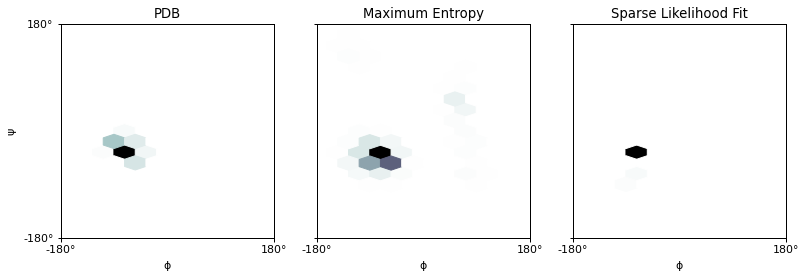

In [1026]:
figure_width = 13

prior = np.loadtxt('prior.csv', delimiter=',')/np.sum(np.loadtxt('prior.csv', delimiter=','))
ls_routine_keywords = {'verbose': 2, 'method': 'lm', 'x_scale': 'jac'}

L = np.zeros(len(E))
minimization = least_squares(me_least_squares_normed_reg, L, args=(E, CC, sigmas, 1, 1, 2.5), jac=jacobian_ls_normed_reg, **ls_routine_keywords)

summe = sum([minimization['x'][index]*CC[key] for index, key in enumerate(E)])
norm = np.amax(summe)

exp_sum = np.exp(summe-norm)
partition = np.sum(prior*exp_sum)
pdf_me = (prior/partition)*exp_sum

fig, axs = plt.subplots(1,3,figsize=(figure_width,figure_width/3.3))
x = np.ndarray.flatten(phi_map)
y = np.ndarray.flatten(psi_map)
C = np.ndarray.flatten(pdf_me)

axs[1].axis([-180,180,-180,180])
axs[1].set_xticks([-180,180])
axs[1].set_yticks([-180,180])
axs[1].set_xticklabels(['-180°','180°'])
axs[1].set_yticklabels([])
axs[1].set_xlabel('$\mathregular{\phi}$')
#axs[1].set_ylabel('$\mathregular{\psi}$')
axs[1].set_title('Maximum Entropy')

grid = 10
axs[1].hexbin(x,y,C,gridsize=(grid,grid),cmap='bone_r')

x2 = phi_dict[residue_nr]
y2 = psi_dict[residue_nr]

#basins = [str(round(basins_olga(np.flipud(np.array(data[str(res)]['R'])))[x],2)) for x,i in enumerate(basins_olga(res_dict[res]['rama_plot']))]

axs[0].axis([-180,180,-180,180])
axs[0].set_xticks([-180,180])
axs[0].set_yticks([-180,180])
axs[0].set_xticklabels(['-180°','180°'])
axs[0].set_yticklabels(['-180°','180°'])
axs[0].set_xlabel('$\mathregular{\phi}$')
axs[0].set_ylabel('$\mathregular{\psi}$')
axs[0].set_title('PDB')
axs[0].hexbin(x2,y2,gridsize=(grid,grid),cmap='bone_r',extent=[-180,180,-180,180])

x3 = np.ndarray.flatten(phi_map)
y3 = np.ndarray.flatten(psi_map)
C3 = np.ndarray.flatten(Z_product)

axs[2].axis([-180,180,-180,180])
axs[2].set_xticks([-180,180])
axs[2].set_yticks([-180,180])
axs[2].set_xticklabels(['-180°','180°'])
axs[2].set_yticklabels([])
axs[2].set_xlabel('$\mathregular{\phi}$')
#axs[1].set_ylabel('$\mathregular{\psi}$')
axs[2].set_title('Sparse Likelihood Fit')
axs[2].hexbin(x3,y3,C3,gridsize=(grid,grid),cmap='bone_r',extent=[-180,180,-180,180])

# Assignment / Questions

A 1) Provide the CCR rates extracted for residue 28, 62 and 72.

A 2) Show the comparison of distributions obtained from MaxEnt, Sparse Likelihhod and the PDB ensemble 2k39 for residues 28, 62, 72.

Q 1) 